In [106]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import statsmodels.api as sm
import seaborn as sns
sns.set(font='IPAGothic')
import os

In [108]:

train = pd.read_csv('C:/Users/abhak/Documents/forcast_in_python/data.csv')

train.head()

,date,store,item,sales
0,1/1/2013,1,1,13
1,1/2/2013,1,1,11
2,1/3/2013,1,1,14
3,1/4/2013,1,1,13
4,1/5/2013,1,1,10


In [109]:
train['date'] = pd.to_datetime(train['date'])
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [110]:
# per 1 store, 1 item
train_df = train[train['store']==1]
train_df = train_df[train['item']==1]
# train_df = train_df.set_index('date')
train_df['year'] = train['date'].dt.year
train_df['month'] = train['date'].dt.month
train_df['day'] = train['date'].dt.dayofyear
train_df['weekday'] = train['date'].dt.weekday

train_df.head()

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5


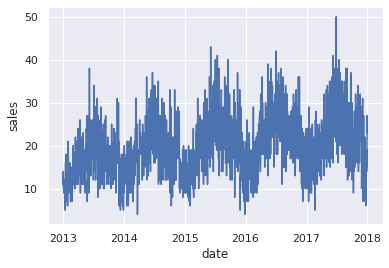

In [111]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df)

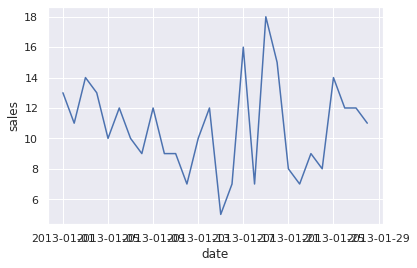

In [112]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df[:28])

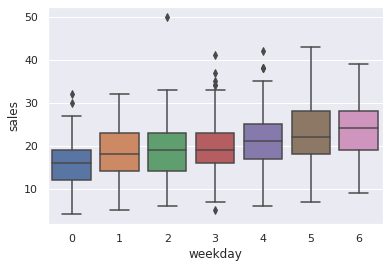

In [113]:
sns.boxplot(x="weekday", y="sales", data=train_df)#monday=0,sunday=6
#from boxpllot we can see that on monday to friday sales is low and weekend sales is high

<Figure size 432x288 with 0 Axes>

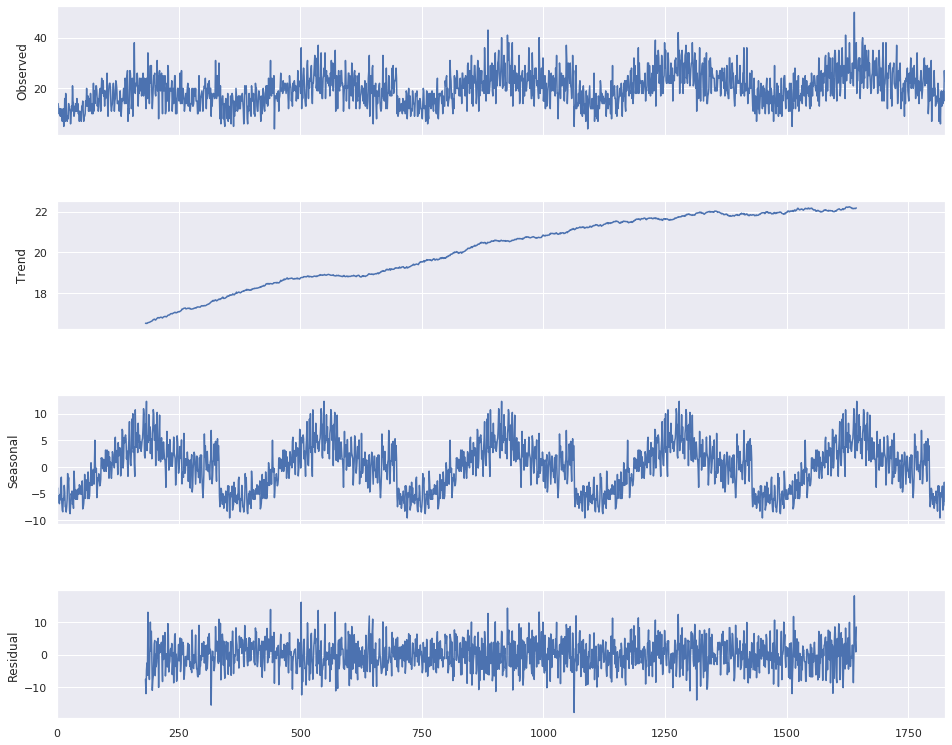

In [114]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_df['sales'], model='additive', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)
# by seeing the trends we can say data is not stationary

In [115]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

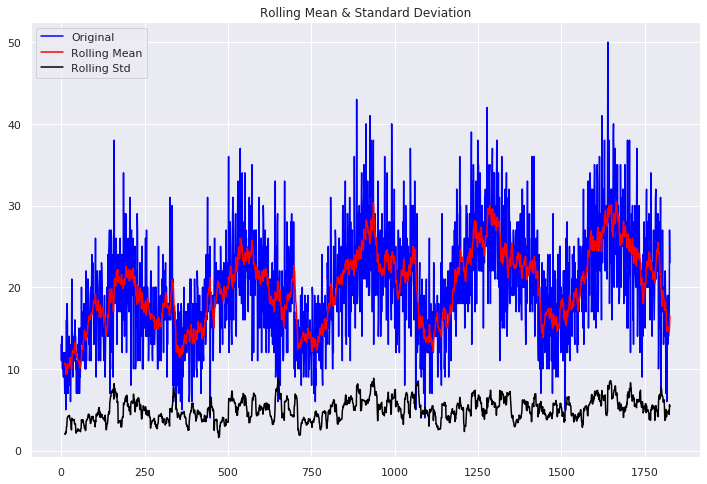

Results of Dickey-Fuller Test:
p-value = 0.0361. The series is likely non-stationary.
Test Statistic                   -2.987278
p-value                           0.036100
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


In [116]:
test_stationarity(train_df['sales'])

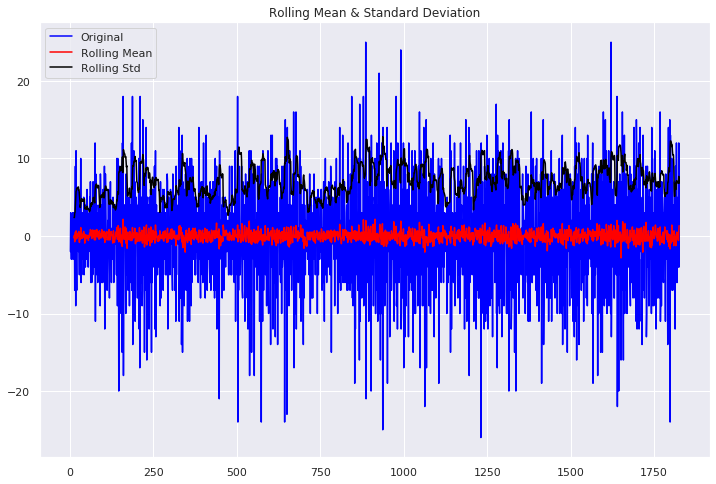

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.520810e+01
p-value                        5.705031e-28
#Lags Used                     2.000000e+01
Number of Observations Used    1.804000e+03
Critical Value (1%)           -3.433980e+00
Critical Value (5%)           -2.863143e+00
Critical Value (10%)          -2.567624e+00
dtype: float64


In [117]:
#To get a stationary data, there's many techiniques. We can use log, differencing etc...
first_diff = train_df.sales - train_df.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

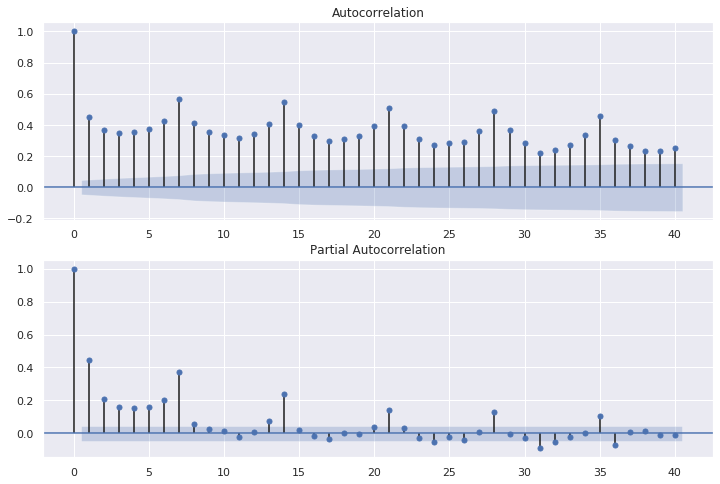

In [118]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.sales, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.sales, lags=40, ax=ax2)# , lags=40

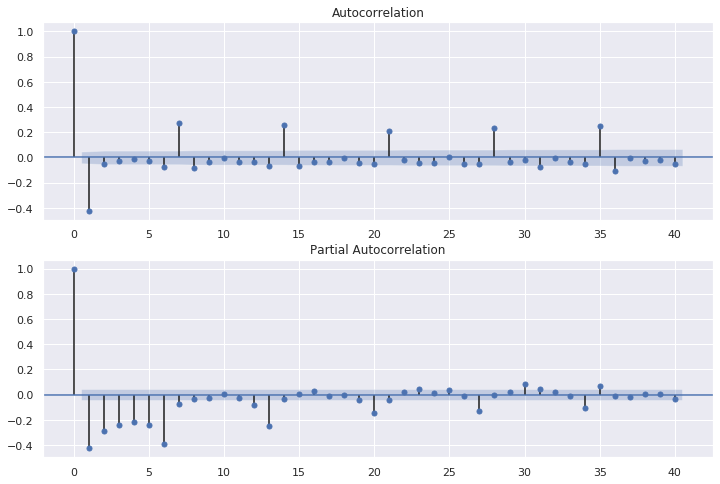

In [119]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

In [120]:
# Here we can see the acf and pacf both has a recurring pattern every 7 periods. Indicating a weekly pattern exists. 
# Any time you see a regular pattern like that in one of these plots, you should suspect that there is some sort of 
# significant seasonal thing going on. Then we should start to consider SARIMA to take seasonality into accuont
#t's easy to determin I. In our case, we see the first order differencing make the ts stationary. I = 1.
#AR model might be investigated first with lag length selected from the PACF or via empirical investigation. In our case, it's clearly that within
#6 lags the AR is significant. Which means, we can use AR = 6


In [121]:
arima_mod1 = sm.tsa.ARIMA(train_df.sales, (6,1,0)).fit(disp=False)
print(arima_mod6.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -5597.668
Method:                       css-mle   S.D. of innovations              5.195
Date:                Thu, 25 Feb 2021   AIC                          11211.335
Time:                        20:01:49   BIC                          11255.410
Sample:                             1   HQIC                         11227.594
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0039      0.025      0.152      0.879      -0.046       0.054
ar.L1.D.sales    -0.8174      0.022    -37.921      0.000      -0.860      -0.775
ar.L2.D.sales    -0.7497      0.026    -

NormaltestResult(statistic=16.426384036996062, pvalue=0.000271054129142071)


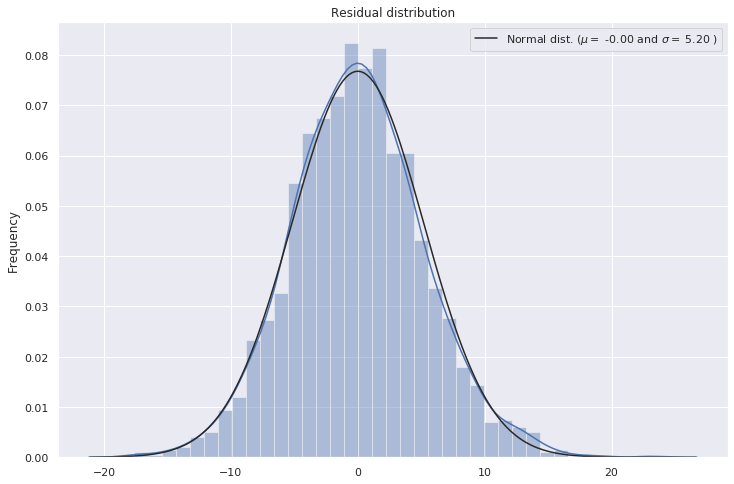

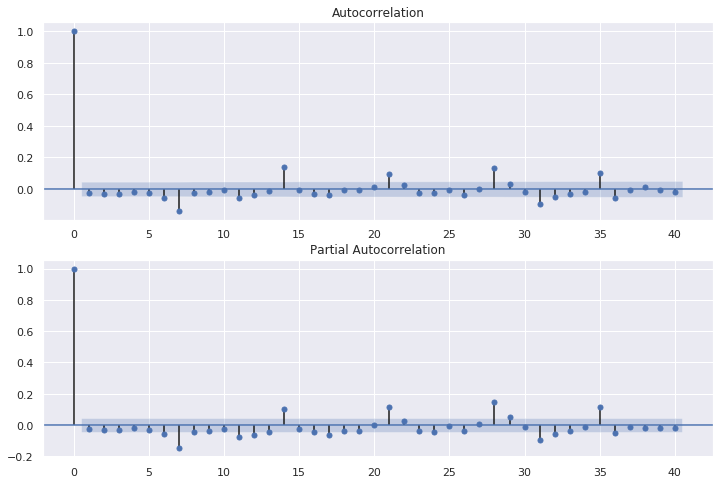

In [122]:
#Analyze the result
#To see how our first model perform, we can plot the residual distribution. See if it's normal dist. And the ACF and PACF. For a good model, we want to see 
#the residual is normal distribution. And ACF, PACF has not significant terms
from scipy import stats
from scipy.stats import normaltest

resid = arima_mod1.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod1.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod1.resid, lags=40, ax=ax2)

In [123]:
#Although the graph looks very like a normal distribution. But it failed the test. Also we see a recurring correlation exists in both 
#ACF and PACF. So we need to deal with seasonality.

sarima_mod2 = sm.tsa.statespace.SARIMAX(train_df.sales, trend='n', order=(6,1,0)).fit()
print(sarima_mod2.summary())

                           Statespace Model Results                           
Dep. Variable:                  sales   No. Observations:                 1826
Model:               SARIMAX(6, 1, 0)   Log Likelihood               -5597.679
Date:                Thu, 25 Feb 2021   AIC                          11209.359
Time:                        20:01:50   BIC                          11247.924
Sample:                             0   HQIC                         11223.585
                               - 1826                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8174      0.021    -39.063      0.000      -0.858      -0.776
ar.L2         -0.7497      0.025    -30.480      0.000      -0.798      -0.702
ar.L3         -0.6900      0.026    -26.686      0.0

NormaltestResult(statistic=16.742690145028856, pvalue=0.00023140408903385627)


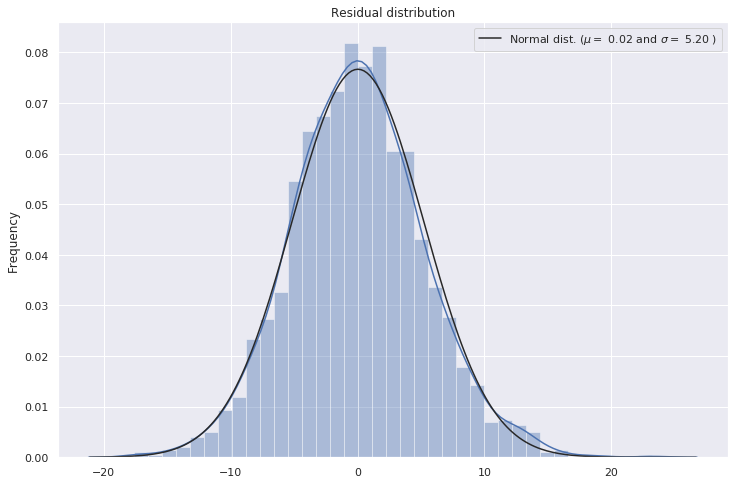

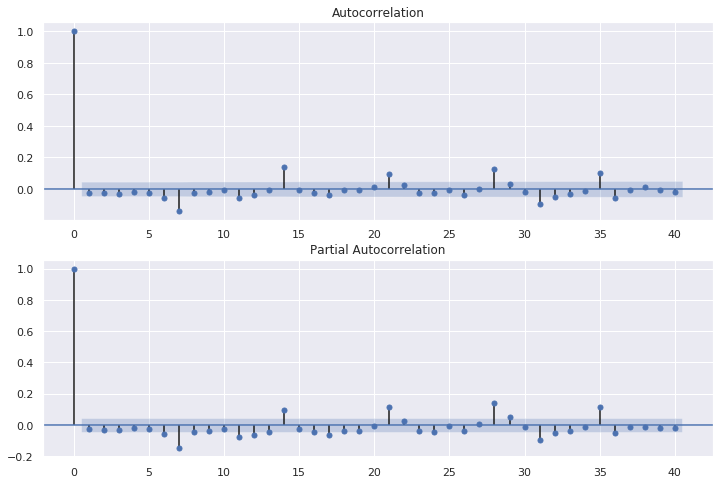

In [124]:
resid = sarima_mod2.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarima_mod2.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarima_mod2.resid, lags=40, ax=ax2)

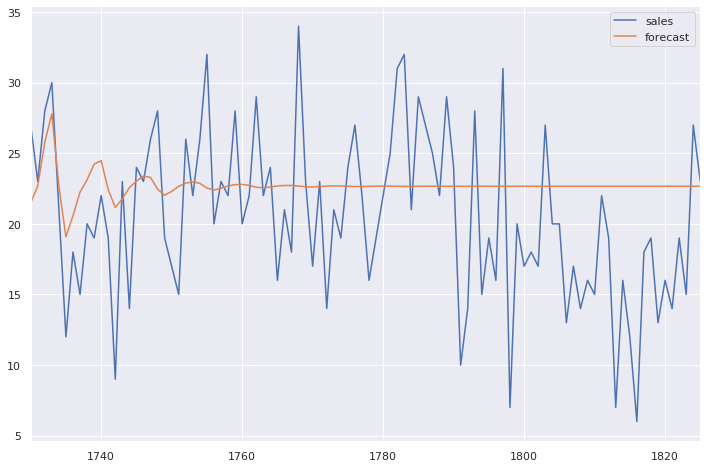

In [125]:
start_index = 1730
end_index = 1826
train_df['forecast'] = sarima_mod2.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

In [126]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [127]:
smape_kun(train_df[1730:1825]['sales'],train_df[1730:1825]['forecast'])

MAPE: 33.01 % 
SMAPE: 25.07 %


In [128]:
holiday = pd.read_csv('C:/Users/abhak/Documents/forcast_in_python/usholiday.csv',header=None, names = ['date', 'holiday'])
holiday['date'] = pd.to_datetime(holiday['date'], yearfirst = True)
holiday.head()

,date,holiday
0,2012-01-02,New Year Day
1,2012-01-16,Martin Luther King Jr. Day
2,2012-02-20,Presidents Day (Washingtons Birthday)
3,2012-05-28,Memorial Day
4,2012-07-04,Independence Day


In [129]:
train_df = train_df.merge(holiday, how='left',on='date')
train_df['holiday_bool'] = pd.notnull(train_df['holiday']).astype(int)
train_df = pd.get_dummies(train_df,columns= ['month','weekday','holiday'] )
train_df.head()
# train_df.shape
# train_df.columns

,date,store,item,sales,year,day,forecast,holiday_bool,month_1,month_2,...,holiday_Christmas Day,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr. Day,holiday_Memorial Day,holiday_New Year Day,holiday_Presidents Day (Washingtons Birthday),holiday_Thanksgiving Day,holiday_Veterans Day
0,2013-01-01,1,1,13,2013,1,NaN,1,1,0,...,0,0,0,0,0,0,1,0,0,0
1,2013-01-02,1,1,11,2013,2,NaN,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,1,1,14,2013,3,NaN,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,1,1,13,2013,4,NaN,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,1,1,10,2013,5,NaN,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
ext_var_list = ['date','year', 'day', 'holiday_bool',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'holiday_Christmas Day', 'holiday_Columbus Day',
       'holiday_Independence Day', 'holiday_Labor Day',
       'holiday_Martin Luther King Jr. Day', 'holiday_Memorial Day',
       'holiday_New Year Day', 'holiday_Presidents Day (Washingtons Birthday)',
       'holiday_Thanksgiving Day', 'holiday_Veterans Day', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6']

In [131]:
exog_data = train_df[ext_var_list]
exog_data = exog_data.set_index('date')
exog_data.head()

,year,day,holiday_bool,month_1,month_2,month_3,month_4,month_5,month_6,month_7,...,holiday_Presidents Day (Washingtons Birthday),holiday_Thanksgiving Day,holiday_Veterans Day,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,2013,1,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2013-01-02,2013,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2013-01-03,2013,3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2013-01-04,2013,4,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2013-01-05,2013,5,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [132]:
train_df = train_df.set_index('date')
# train_df = train_df.reset_index()
train_df.head()

,store,item,sales,year,day,forecast,holiday_bool,month_1,month_2,month_3,...,holiday_Christmas Day,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr. Day,holiday_Memorial Day,holiday_New Year Day,holiday_Presidents Day (Washingtons Birthday),holiday_Thanksgiving Day,holiday_Veterans Day
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,13,2013,1,NaN,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2013-01-02,1,1,11,2013,2,NaN,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-03,1,1,14,2013,3,NaN,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-04,1,1,13,2013,4,NaN,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-05,1,1,10,2013,5,NaN,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
start_index = '2017-10-01'
end_index = '2017-12-31'
# exog_data.head()

In [134]:
%%time
sarimax_mod6 = sm.tsa.statespace.SARIMAX(endog = train_df.sales[:start_index],
                                        exog = exog_data[:start_index],  
                                        trend='n', order=(6,1,0), seasonal_order=(0,1,1,7)).fit()
print(sarimax_mod6.summary())

                                 Statespace Model Results                                
Dep. Variable:                             sales   No. Observations:                 1735
Model:             SARIMAX(6, 1, 0)x(0, 1, 1, 7)   Log Likelihood               -5144.733
Date:                           Thu, 25 Feb 2021   AIC                          10369.465
Time:                                   20:16:31   BIC                          10587.631
Sample:                               01-01-2013   HQIC                         10450.167
                                    - 10-01-2017                                         
Covariance Type:                             opg                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
year                                           -432.

In [135]:
start_index = '2017-10-01'
end_index = '2017-12-30'
end_index1 = '2017-12-31'

In [137]:
sarimax_mod6.forecast(steps = 121,exog = exog_data[start_index:end_index])

ValueError: Provided exogenous values are not of the appropriate shape. Required (121, 32), got (91, 32).

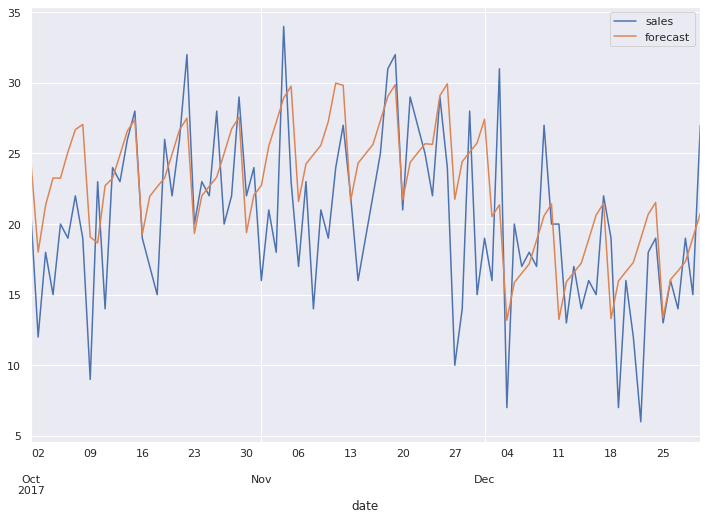

In [136]:
train_df['forecast'] = sarimax_mod6.predict(start = pd.to_datetime(start_index), end= pd.to_datetime(end_index1),
                                            exog = exog_data[start_index:end_index], 
                                            dynamic= True)  

train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

In [138]:
smape_kun(train_df[start_index:end_index]['sales'],train_df[start_index:end_index]['forecast'])

MAPE: 26.99 % 
SMAPE: 21.80 %
